## Оценка влияния нового дизайна рекламы

Для начала возьмем датасет, [выложенный на данной странице](https://www.kaggle.com/datasets/zahrazolghadr/ab-test).

Для этих данных можно найти следующее описание:

*В данном исследовании необходимо проанализировать результаты A/B-теста, проведенного онлайн-магазином. Компания разработала новый дизайн веб-страниц, чтобы попытаться увеличить количество пользователей, которые «конвертируются», то есть количество пользователей, которые решают заплатить за продукт компании. Ваша цель -- проанализировать представленные данные, чтобы помочь компании понять, следует ли им внедрять эту новую страницу, сохранять старую страницу или, возможно, проводить эксперимент дольше, чтобы принять решение.*

Загрузим данные и посмотрим на них.
Изначально данные хранятся в формате csv и удобнее всего импортировать их с помощью библиотеки pandas.
Поскольку мы хотим провести "последовательный" анализ, отсортируем данные по timestamp, т.е. по времени каждой записи.
Обратите внимание, что в данном датасете почти все пользователи появляется только один раз, но в реальных данных нам пришлось бы дополнительно усреднять данные по каждому пользователю отдельно.
В данном же случае удалим всех пользователей, которые имеют по 2 и более записи (такие составляют около 1% от всех данных, поэтому от их удаления мы ничего не потеряем).

In [1]:
import pandas as pd

df = pd.read_csv('https://drive.google.com/uc?export=download&id=1bLhznTSMaIcDFF-DQ7xUNofYfS-duwn7').sort_values('timestamp')

df = df.drop_duplicates(subset='user_id', keep=False) # удалим дубликаты по user_id

print(df.shape)
df.head(10)

(286690, 5)


,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0
191378,762651,2017-01-02 13:42:28.522322,treatment,new_page,0
111830,722516,2017-01-02 13:42:34.033708,treatment,new_page,0
1985,688937,2017-01-02 13:42:41.406986,treatment,new_page,0
26725,781125,2017-01-02 13:42:45.090432,treatment,new_page,0
112584,799109,2017-01-02 13:42:45.219901,control,old_page,0


Немного исследуем данные. Сравним число пользователей в каждой из групп.

In [2]:
counts = df.groupby(['group', 'landing_page']).size()
print("Число пользователей по группам:")
print(counts)

Число пользователей по группам:
group      landing_page
control    old_page        143293
treatment  new_page        143397
dtype: int64


Подсмотрим в итоговый результат и попробуем "угадать", помог ли новый дизайн.
В реальном случае, конечно, так делать не получится, но для учебных целей позволим себе эту данность. Запомним, что средний уровень конверсии в каждой из групп составляет примерно 12%.

In [ ]:
print("Control conversion rate ", df[df['group'] == 'control']['converted'].mean())
print("Treatment conversion rate ", df[df['group'] == 'treatment']['converted'].mean())

Control conversion rate  0.12017335110577627
Treatment conversion rate  0.11872633318688676


Для начала воспользуемся классическим тестом, который можно применить в данной ситуации. Возьмем для этого тест из библиотеки statsmodels, который сравнивает два биномиальных распределения. На вход подается число успехов и число экспериментов, а также предполагаемая разница в вероятностях успеха (в нашем случае value = 0).

In [ ]:
from statsmodels.stats.proportion import test_proportions_2indep

statistic, pvalue = test_proportions_2indep(
    df[df['group'] == 'control']['converted'].sum(),
    df[df['group'] == 'control']['converted'].shape[0],
    df[df['group'] == 'treatment']['converted'].sum(),
    df[df['group'] == 'treatment']['converted'].shape[0], value=0)
statistic, pvalue

(1.1944576869478971, 0.23229898290776396)

А теперь проведем эксперимент, а именно симулируем подсматривание в данные.
Каждые 1000 пользователей будем считать p-value и посмотрим, можно ли по этому значению получить какой-то адекватный вывод.

In [ ]:
p_values = []

for i in range(1000, df.shape[0], 1000):
    data = df.head(i)
    p_values.append(
        test_proportions_2indep(
            data[data['group'] == 'control']['converted'].sum(),
            data[data['group'] == 'control']['converted'].shape[0],
            data[data['group'] == 'treatment']['converted'].sum(),
            data[data['group'] == 'treatment']['converted'].shape[0], value=0)[1]
    )

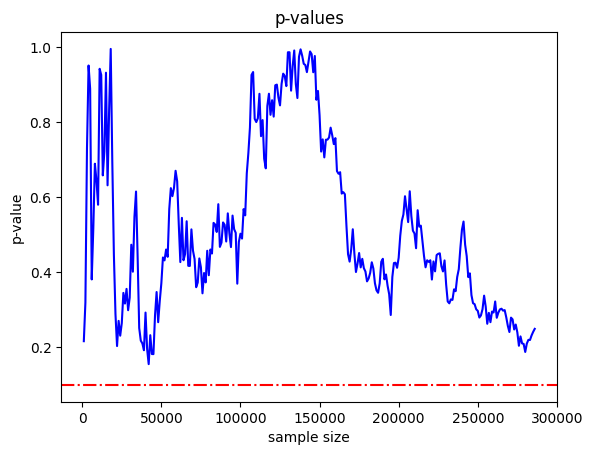

In [ ]:
import matplotlib.pyplot as plt

plt.title("p-values")
plt.xlabel("sample size")
plt.ylabel("p-value")
plt.plot(range(1000, df.shape[0], 1000), p_values, color="blue")
plt.axhline(y = 0.1, color = 'r', linestyle = '-.')

plt.show()

Ничего страшного не случилось, p-value не опускался ниже 0.2, так что от подсматривания сильно хуже не стало бы. Однако стоит отметить как сильно менялось p-value в ходе эксперимента (от 0.2 до почти 1), что говорит о том что все промежуточные значения не являются достаточно надежными.

Попробуем провести другой эксперимент. Мы знаем, что доля конверсии в тестовой выборке составляет примерно 12%. Попробуем воспользоваться биномиальным тестом, чтобы проверить, было ли это так в ходе всего тестирования.

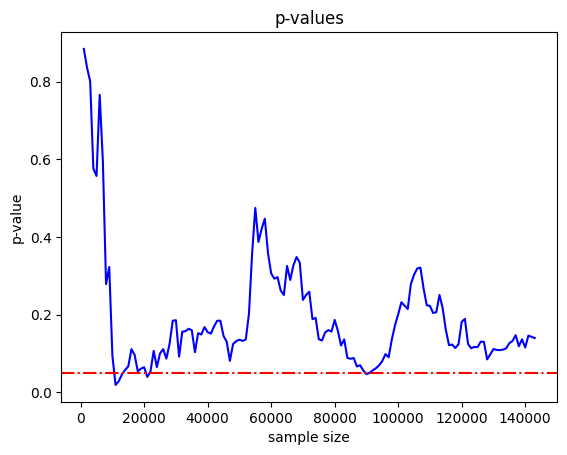

In [ ]:
from statsmodels.stats.proportion import binom_test

expected_p = 0.12
p_values = []

data = df[df['group'] == 'treatment']

for i in range(1000, data.shape[0], 1000):
    p_values.append(
        binom_test(data.head(i).converted.sum(), data.head(i).converted.shape[0], expected_p)
    )

plt.title("p-values")
plt.xlabel("sample size")
plt.ylabel("p-value")
plt.plot(range(1000, data.shape[0], 1000), p_values, color="blue")
plt.axhline(y = 0.05, color = 'r', linestyle = '-.')

plt.show()

И тут мы видим, что по крайней мере один раз наше p-value упало ниже 0.05, то есть мы должны были отвергнуть гипотезу о том, что уровень конверсии составляет 0.12. Это довольно стандартный результат "подглядывания".

Теперь воспользуемся стандартным методом последовательного анализа.

Выдвинем две гипотезы для тестовой выборки. H_0: p = 0.12 против H_1: p = 0.13.

In [ ]:
from math import pow, log, exp

def sprt(count, nobs, p0, p1, alpha=0.05, beta=0.2):
    A = beta / (1 - alpha)
    B = (1 - beta) / alpha

    ratio = exp(
        count * log(p1 / p0) + (nobs - count) * log((1 - p1) / (1 - p0))
    )

    if ratio <= A:
        return ratio, "H0"
    elif ratio >= B:
        return ratio, "H1"

    return ratio, "None"

143397


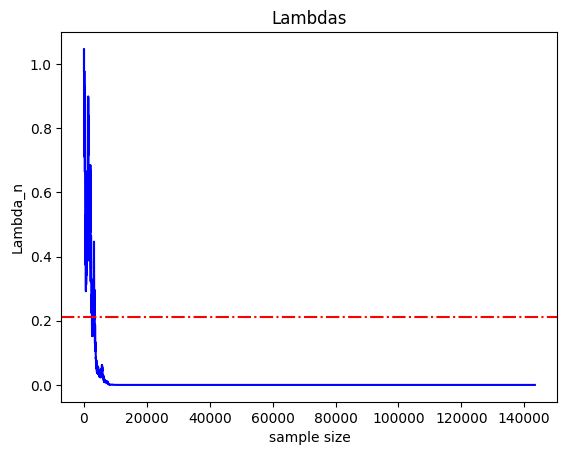

In [ ]:
H0_p = 0.12
H1_p = 0.13

alpha = 0.05
beta = 0.2
A = beta / (1 - alpha)
B = (1 - beta) / alpha

sprt_values = []
data = df[df['group'] == 'treatment']

needed_n = data.shape[0]

for i in range(10, data.shape[0], 10):
    result = sprt(data.head(i).converted.sum(), data.head(i).converted.shape[0], H0_p, H1_p, alpha, beta)
    sprt_values.append(
        result[0]
    )

print(needed_n)

plt.title("Lambdas")
plt.xlabel("Sample size")
plt.ylabel("Lambda_n")
plt.plot(range(10, 10 * len(sprt_values) + 1, 10), sprt_values, color="blue")
plt.axhline(y = A, color = 'r', linestyle = '-.')

plt.show()

Мы видим что довольно быстро удалось пробить "пол", то есть правдоподобие нулевой гипотезы значительно выше правдоподобия альтернативной.

Посмотрим чуть внимательнее как именно происходило это пробитие.

2530


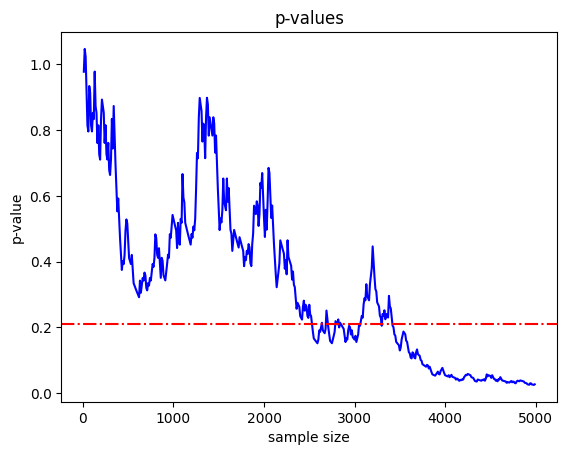

In [ ]:
sprt_values = []
data = df[df['group'] == 'treatment']

needed_n = data.shape[0]

for i in range(10, 5000, 10):
    result = sprt(data.head(i).converted.sum(), data.head(i).converted.shape[0], H0_p, H1_p, alpha, beta)
    sprt_values.append(
        result[0]
    )
    if result[1] == 'H0':
        needed_n = min(needed_n, i)

print(needed_n)

plt.title("Lambdas")
plt.xlabel("Sample size")
plt.ylabel("Lambda_n")
plt.plot(range(10, 10 * len(sprt_values) + 1, 10), sprt_values, color="blue")
plt.axhline(y = A, color = 'r', linestyle = '-.')

plt.show()

Как мы видим, впервые оно произошло после 2610 наблюдений. В этот момент нам следовало бы остановить тестирование, но мы его продолжили и увидели что график немного "скакал" в районе указанной линии.

Теперь вопрос: что нам стоило сделать, чтобы опустить эту линию ниже (то есть, быть более увереными при принятии нулевой гипотезы)? Правильный ответ достаточно прост - нужно уменьшить вероятность ошибки второго рода. Уменьшим значение beta.

4020


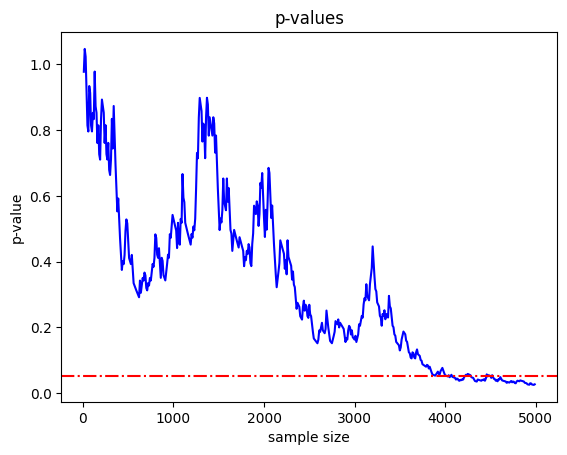

In [ ]:
alpha = 0.05
beta = 0.05
A = beta / (1 - alpha)
B = (1 - beta) / alpha

sprt_values = []

needed_n = data.shape[0]

for i in range(10, 5000, 10):
    result = sprt(data.head(i).converted.sum(), data.head(i).converted.shape[0], H0_p, H1_p, alpha, beta)
    sprt_values.append(
        result[0]
    )
    if result[1] == 'H0':
        needed_n = min(needed_n, i)

print(needed_n)

plt.title("Lambdas")
plt.xlabel("Sample size")
plt.ylabel("Lambda_n")
plt.plot(range(10, 10 * len(sprt_values) + 1, 10), sprt_values, color="blue")
plt.axhline(y = A, color = 'r', linestyle = '-.')

plt.show()

Как мы видим, критическое значение уменьшилось, что потребовало пусть и бОльшего числа наблюдений, но результат все равно более корректный.

Вспомним теперь, что у нас все-таки А/Б тестирование, так что хотелось бы использовать обе выборки. Реализует Always Valid Inference на основе mSPRT.

In [ ]:
import numpy as np

def lambda_function(n, mu_a, mu_b, tau_sq):
    v_n = (mu_a * (1 - mu_a) + mu_b * (1 - mu_b))
    nts = n * tau_sq
    if v_n == 0:
        return 1.0
    else:
        return (np.sqrt(v_n / (v_n + nts)) *
                np.exp(((n * nts) * (mu_a - mu_b)**2) /
                       ((2.0 * v_n) * (v_n + nts))))

def valid_p_value(a_obs, b_obs, tau_sq=0.01):
    mu_a = a_obs.mean()
    mu_b = b_obs.mean()
    return min(1, 1 / lambda_function(len(a_obs), mu_a, mu_b, tau_sq))


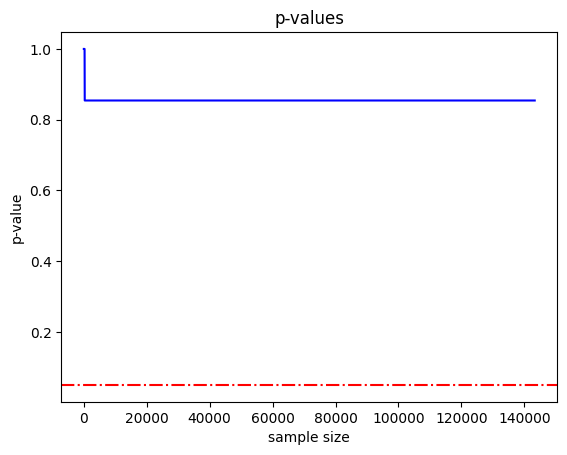

In [ ]:
control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']
length = min(treatment.shape[0], control.shape[0])
control = control.head(length)
treatment = treatment.head(length)

p_values = []
p_value = 1.0

for i in range(10, length, 10):
    p_value = min(p_value, valid_p_value(control.head(i), treatment.head(i)))
    p_values.append(p_value)

plt.title("p-values")
plt.xlabel("sample size")
plt.ylabel("p-value")
plt.plot(range(10, length, 10), p_values, color="blue")
plt.axhline(y = 0.05, color = 'r', linestyle = '-.')


Видим, что p-value в ходе всего тестирования оставалось достаточно большим (что не позволяет нам говорить о разностях в уровнях конверсии). Конечно, в этом случае мы будем ждать условия p-value < alpha до бесконечности, поэтому стоит заранее оценить максимальное число наблюдений, при котором мы останавливаемся.

Однако надо вспомнить, что есть параметр tau, значение которого мы не подбирали. Посмотрим, как будет вести себя кривая при разных значениях tau.

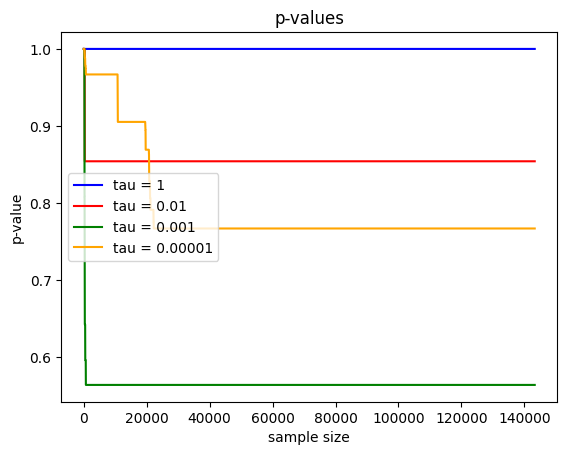

In [ ]:
control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']
length = min(treatment.shape[0], control.shape[0])
control = control.head(length)
treatment = treatment.head(length)

p_values_1 = [1]
p_values_01 = [1]
p_values_001 = [1]
p_values_00001 = [1]


for i in range(10, length, 10):
    for l, tau in zip([p_values_1, p_values_01, p_values_001, p_values_00001], [1, 0.01, 0.001, 0.00001]):
        p_value = valid_p_value(control.head(i), treatment.head(i), tau_sq = tau)
        l.append(min(l[-1], p_value))

plt.title("p-values")
plt.xlabel("sample size")
plt.ylabel("p-value")
plt.plot(range(10, length, 10), p_values_1[:-1], color="blue", label="tau = 1")
plt.plot(range(10, length, 10), p_values_01[:-1], color="red", label="tau = 0.01")
plt.plot(range(10, length, 10), p_values_001[:-1], color="green", label="tau = 0.001")
plt.plot(range(10, length, 10), p_values_00001[:-1], color="orange", label="tau = 0.00001")
plt.legend()


Видим, что разные tau дают различные кривые. Более того, минимальное значение p-value не коррелирует со значением tau - p-value для tau=0.001 лежит выше чем для tau=0.00001. Таким образом, нужно обязательно искать верное "промежуточное" значение tau, ибо крайние значения будут склонны никогда не отвергать гипотезу.

Теперь реализуем подход, описанный в блогпосте. Нарисуем график разницы числа  успехов (зеленая линия) и проверим визуально, лежала ли она выше необходимого числа (черная линия).

In [ ]:
from math import sqrt

# evan's miller approach:
# https://www.evanmiller.org/sequential-ab-testing.html

def score(T, C, N):
    if T - C >= 2 * sqrt(N):
        return 'There is the effect'
    if T + C >= N:
        return 'There is no effect'
    return None

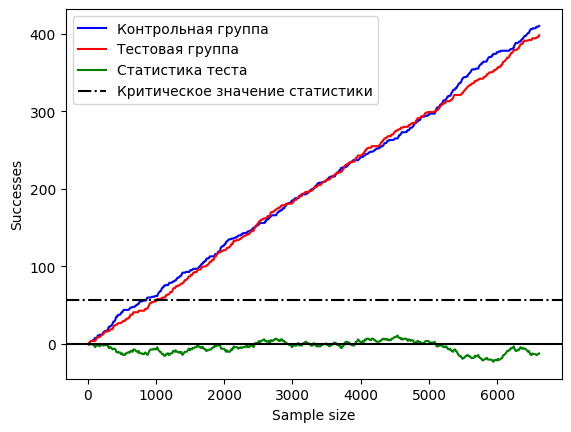

In [ ]:
N = 808 # https://www.evanmiller.org/ab-testing/sequential.html

control_successes = []
treatment_successes = []

for i in range(10, df.shape[0], 10):
    data = df.head(i)
    T = data[data['group'] == 'treatment']['converted'].sum()
    C = data[data['group'] == 'control']['converted'].sum()
    control_successes.append(C)
    treatment_successes.append(T)
    if score(T, C, N) is not None:
        break

plt.xlabel("Sample size")
plt.ylabel("Successes")
plt.plot([i * 10 for i in range(1, len(control_successes) + 1)], control_successes, color="blue", label="Контрольная группа")
plt.plot([i * 10 for i in range(1, len(control_successes) + 1)], treatment_successes, color="red", label="Тестовая группа")
plt.plot([i * 10 for i in range(1, len(control_successes) + 1)], [T - C for T, C in zip(treatment_successes, control_successes)], color="green", label="Статистика теста")

plt.axhline(y = 2 * sqrt(N), color = 'black', linestyle = '-.', label="Критическое значение статистики")
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.legend()

plt.show()

## Главная страница онлайн кинотеатра

В онлайн кинотеатре решили увеличить процент пользователей, которые видят главную страницу и регистрируются на сайте. Для этого было предложено протестировать три различных дизайна главной страницы.

Дизайн А: На главной странице большими картинками показаны рекомендуемые к просмотру фильмы (фичер)

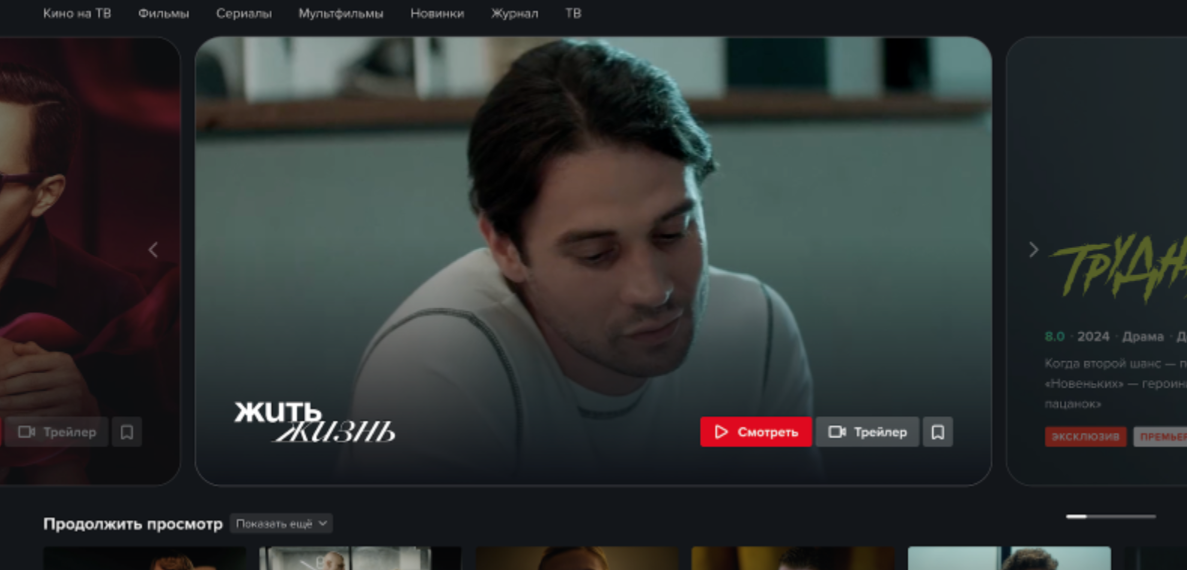

Дизайн B: Вместо рекомендуемых фильмов (фичера) показан рекламный баннер (заглушка):

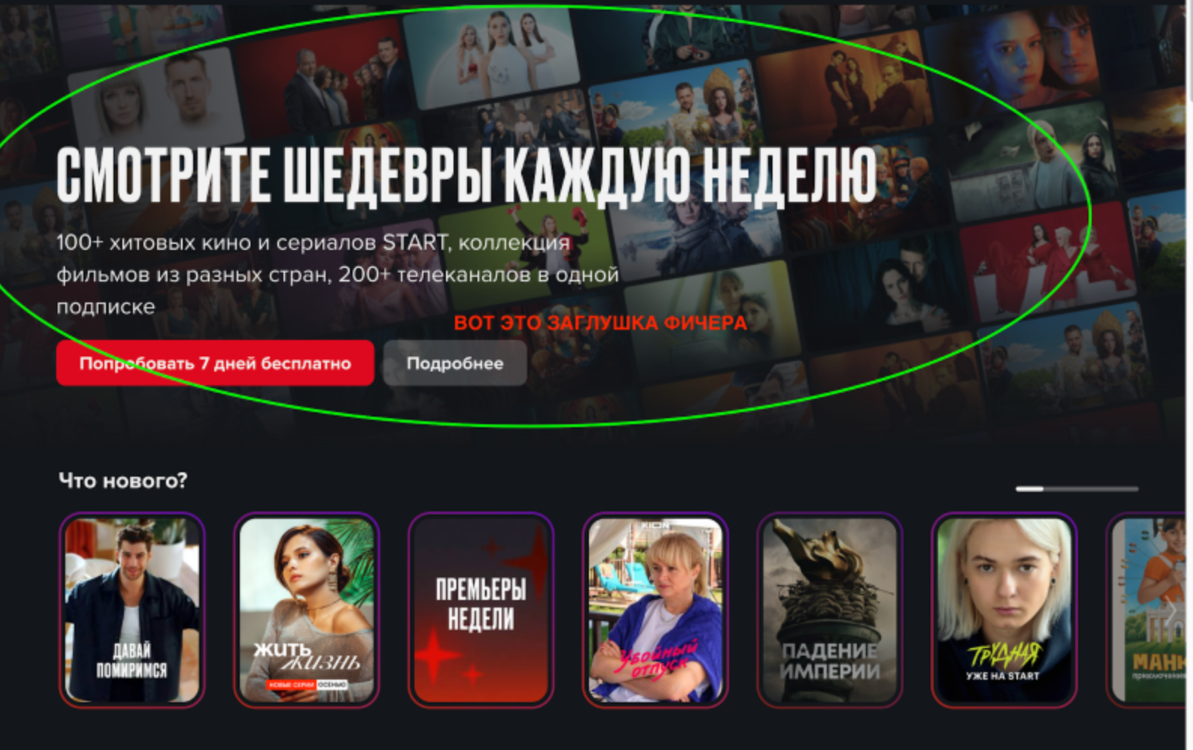

Дизайн C: Похож на дизайн B, но рекламный баннер и раздел "Что нового?" поменяли местами.

**Дизайн АБ теста**

Было пользователям случайным образом был показан 1 из 3 вариантов.

В качестве метрики оценивалась доля новых пользователей, которые зашли на главную страницу и зарегистрировались на сайте.

Вновь загрузим данным и посмотрим на них.

In [5]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1d7uIPNpWtwA9m94pTqBncicugh4AFPo7',decimal=",").sort_values('day')

print(df.shape)
df.head(10)

(300, 4)


,measure,group,day,value
0,user_to_reg,control,1,0.215228
1,user_to_reg,group_b,1,0.283389
2,user_to_reg,group_c,1,0.272398
3,user_to_reg,control,2,0.264191
4,user_to_reg,group_b,2,0.242994
5,user_to_reg,group_c,2,0.252411
6,user_to_reg,control,3,0.256565
7,user_to_reg,group_b,3,0.243836
8,user_to_reg,group_c,3,0.236917
11,user_to_reg,group_c,4,0.273777


Как мы видим, имеется три группы - одна контрольная и две тестовые. Требуется понять, помог ли какой-либо из новых дизайнов повысить конверсию.

Предположим (с допущениями) что уровень конверсии каждый день имеет нормальное распределение с некоторой дисперсией (которую стоит оценить по предыдущим данным). Предположим, что по предыдущим рекламным кампаниям мы узнали что sigma_sq = 0.001.

Реализуем msprt для нормальных выборок.

In [ ]:
import numpy as np

def lambda_function(n, mu_a, mu_b, sigma_sq, tau_sq):
    if n == 0:
        return 1.0
    den = 2 * sigma_sq + n * tau_sq
    return np.sqrt(2 * sigma_sq / den) * np.exp(((n ** 2 * tau_sq  * (mu_a - mu_b)**2) / (4 * sigma_sq * den)))

def valid_p_value(a_obs, b_obs, sigma_sq = 0.001, tau_sq=0.0001):
    mu_a = sum(a_obs) / len(a_obs)
    mu_b = sum(b_obs) / len(b_obs)
    return min(1, 1 / lambda_function(len(a_obs), mu_a, mu_b, sigma_sq, tau_sq))


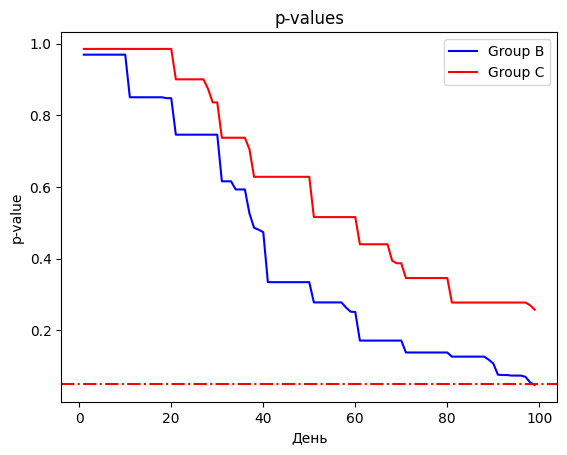

In [ ]:
import matplotlib.pyplot as plt

control = list(df[(df['group'] == 'control') & (df['measure'] == 'user_to_reg')]['value'])
groupb = list(df[(df['group'] == 'group_b') & (df['measure'] == 'user_to_reg')]['value'])
groupc = list(df[(df['group'] == 'group_c') & (df['measure'] == 'user_to_reg')]['value'])


pval_b = [1]
pval_c = [1]

for i in range(1, len(control)):
    pval_b.append(min(pval_b[-1], valid_p_value(control[:i], groupb[:i])))
    pval_c.append(min(pval_c[-1], valid_p_value(control[:i], groupc[:i])))

plt.title("p-values")
plt.xlabel("День")
plt.ylabel("p-value")
plt.plot(range(1, len(control)), pval_b[1:], color="blue", label="Group B")
plt.plot(range(1, len(control)), pval_c[1:], color="red", label="Group C")
plt.axhline(y = 0.05, color = 'r', linestyle = '-.')
plt.legend()


Как мы видим, в последний день p-value для группы B стало меньше 0.05, из чего можно сделать вывод что этот дизайн действительно успешный и он позволяет повысить уровень конверсии. Можно обратить внимание, что уровень конверсии в группе C также постепенно становится меньше, т.е. этот дизайн также успешен, но мы еще не можем сказать что он статистическо значимо успешнее контрольной группы.